# **Test on the capabilities of our model** 🏋

In [1]:
from model import *
from optax import adam
from src.datagen import Equations
import os
from jax import jit, vmap, random, lax
import jax
import matplotlib.pyplot as plt
import time
import scienceplots

jax.config.update("jax_enable_x64", True)
plt.style.use('science')

## Test the purely raw model

In [ ]:
state_variables = 20
expected_number_of_nls = 10
input_dim = state_variables * expected_number_of_nls
output_dim = state_variables

model = ZeroLayersNN(N=input_dim, L=expected_number_of_nls, output_dim=state_variables)
seed = 42
train_batch_size = 32
test_batch_size = 64


dummy_input = jnp.zeros((train_batch_size, input_dim))
key = random.key(seed)
key, subkey = random.split(key)
params = model.init(subkey, dummy_input)
optimizer = adam(learning_rate=0.001)
state = TrainState.create(apply_fn=model.apply, params=params, tx=optimizer)
print(f"There are {count_params(state.params['params'])} learnable parameters in the current architecture.")

There are 4080 learnable parameters.


Then we create the random non linearities:

- **generate_alphabeta**: This function generates orthonormal basis vectors using QR decomposition. It takes three parameters: `dim` (the dimension of the matrix), `num` (the number of basis vectors), and `seed` (a seed for random number generation). The function creates a random matrix `A` of shape `(dim, num)` and then performs QR decomposition on `A` to obtain an orthonormal matrix `Q`. The function returns `Q`.
- **generate_callable_functions**: This function generates a set of callable functions based on the orthonormal basis vectors generated by `generate_alphabeta`. It takes three parameters: `dim` (the dimension of the matrix), `num` (the number of functions to generate), and `seed` (a seed for random number generation). The function splits the basis vectors into three parts: `alphas`, `betas`, and `gammas`. It then defines a nested function `make_function` that creates a callable function using these vectors. The `make_function` uses JAX's `jit` decorator to compile the function for faster execution. The main function returns a tuple containing the generated functions and the transposed basis vectors.

In [3]:
def generate_alphabeta(dim, num, spread, seed):

    key = random.key(seed)
    shape = (dim, num)
    A = random.normal(key, shape)
    #Q, _, _ = jnp.linalg.svd(A, full_matrices=True)
    return A * spread

def generate_callable_functions(dim, num, spread, seed):

    bases = generate_alphabeta(dim, num, spread, seed)  # Get num basis vectors
    bases = bases.T
    alphas = bases[:,:dim//2]  # First half of Q are alphas
    gammas = bases[:,dim//2:]

    def make_function(alpha, gamma):
        @jit
        def func(x):
            return (alpha[0] * nn.relu(x + gamma[0]) +
                    alpha[1] * nn.relu(x + gamma[1]) +
                    alpha[2] * nn.relu(x + gamma[2]))
        return func
        
    return tuple([make_function(alphas[i], gammas[i]) for i in range(num)]), bases

Now we want to work with the simplest case possible.


In [4]:
dims = 6
n_nls = 10
spread = 5
alphagamma = generate_alphabeta(dims, n_nls, spread, seed)
alphagamma = alphagamma.T
alphas = alphagamma[:,:dims//2]  # First half of Q are alphas
gammas = alphagamma[:,dims//2:]
print(alphagamma.shape)
print("Alphas:", alphas)
print("Gammas:", gammas)

non_lins, vec_nls = generate_callable_functions(dims, n_nls, spread, seed)

config = {
    "n_vars": state_variables,
    "n_eqs": state_variables,
    "bounds_addends": (1, 3),
    "bounds_multiplicands": (1, 1),
    "non_lins": non_lins,
    "sym_non_lins": None,
    "distribution": "uniform",
    "a": None,
    "b": None,
    "sigma": None,
    "p": None,
    "seed": seed
}

(10, 6)
Alphas: [[-2.17664396e+00 -6.29406871e+00 -5.19491848e+00]
 [-1.23063727e+00  8.39689247e+00  3.82128144e+00]
 [-9.10063268e-02 -2.85060975e-01 -6.88120963e+00]
 [-1.00054252e+01 -9.11655876e-03 -1.46862708e+00]
 [ 4.36819991e+00  3.32054825e+00 -2.63901110e-01]
 [ 6.63121219e+00 -3.01020399e+00  9.54288332e+00]
 [ 5.41533972e+00  4.89783329e+00  7.23484906e-01]
 [-5.41601000e+00 -7.14198085e+00 -5.05650263e+00]
 [-1.18614539e+00  3.99605577e+00  1.88592948e+00]
 [ 1.87047068e-01  2.75162241e-01 -1.03215941e+00]]
Gammas: [[ 3.93060866  7.0637436  -4.58035497]
 [ 4.3068647   1.51231557  7.24401073]
 [ 1.10358323  8.86721081  2.59579719]
 [ 5.71528543 -5.84395951  4.20033569]
 [-6.0367638   4.64757295  1.70315899]
 [ 2.13592935 -3.90751904 -0.52488645]
 [-6.3757238  -4.16169437 -0.97483095]
 [-3.1713859  -8.23583881 -5.1379733 ]
 [ 2.76504282  1.04654252 -1.91848673]
 [-6.01914822  0.83512535  2.30577237]]


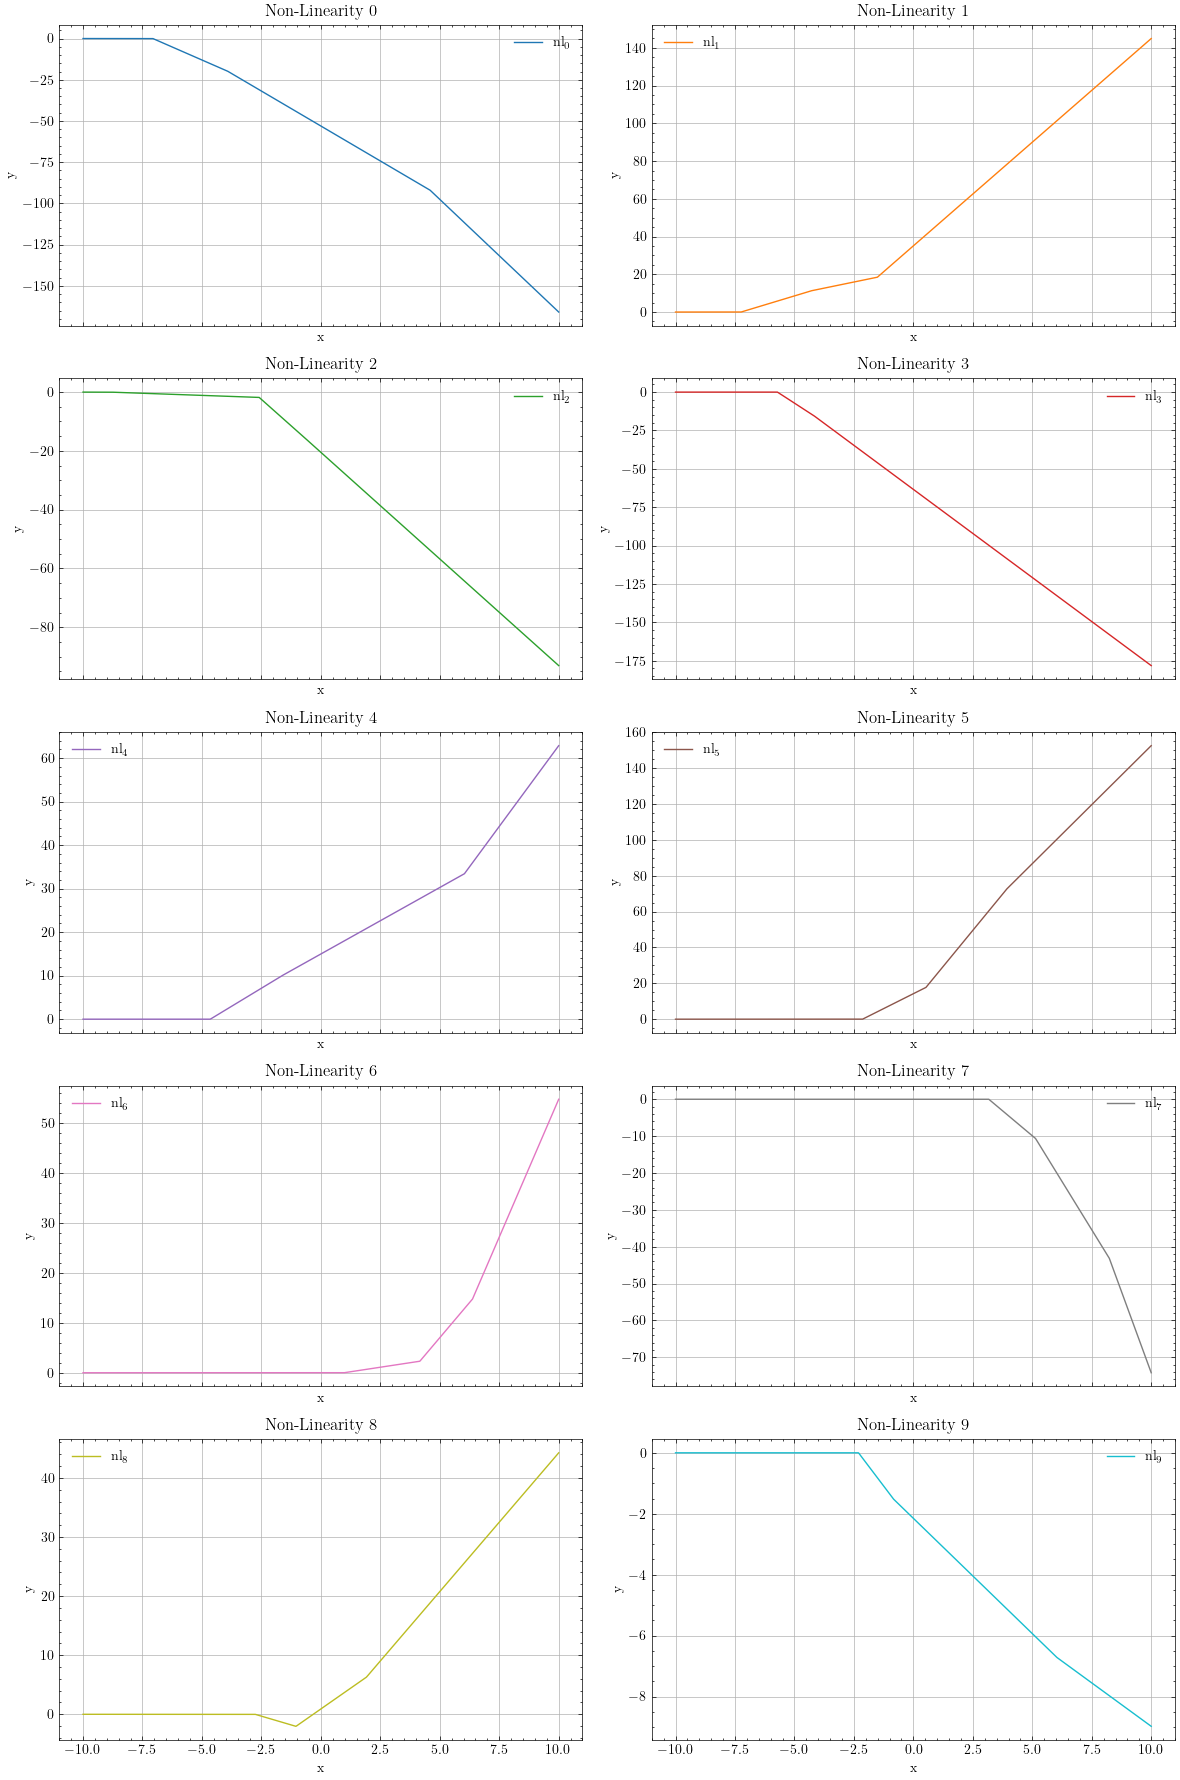

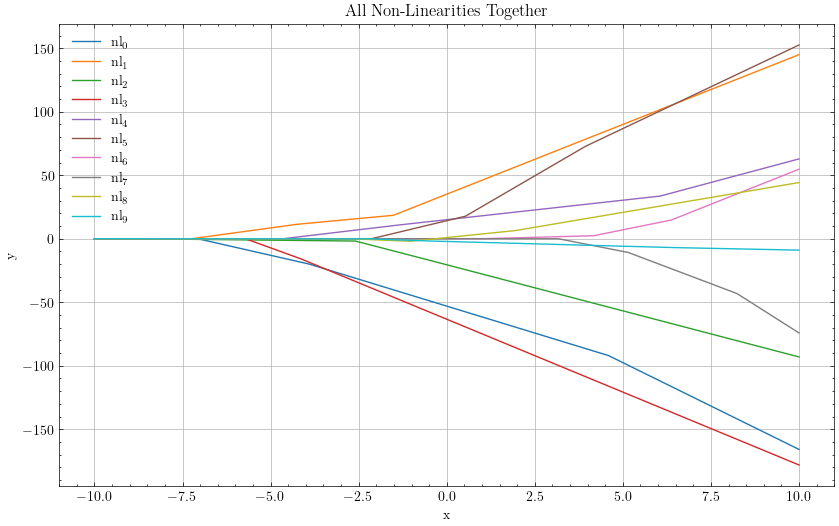

In [5]:
# Create subplots for individual non-linearities
num_funcs = len(non_lins)
cols = 2  # Number of columns in the grid
rows = (num_funcs + 1) // cols  # Rows for individual plots
fig, axes = plt.subplots(rows, cols, figsize=(12, 18), sharex=True)

x = jnp.linspace(-10, 10, 1000)
colors = plt.cm.tab10(range(num_funcs))  # Use a colormap to assign colors

# Plot each callable's result in separate subplots
for i, func in enumerate(non_lins):
    row, col = divmod(i, cols)
    ax = axes[row, col]
    y = func(x)
    ax.plot(x, y, label=r"$\text{nl}_{%d}$" % i, color=colors[i])
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_title(f'Non-Linearity {i}')
    ax.legend()
    ax.grid(True)

# Adjust layout for individual plots
plt.tight_layout()
plt.show()
plt.clf()
plt.close()

# Create a separate figure for all non-linearities together
plt.figure(figsize=(10, 6))
for i, func in enumerate(non_lins):
    y = func(x)
    plt.plot(x, y, label=r"$\text{nl}_{%d}$" % i, color=colors[i])
plt.xlabel('x')
plt.ylabel('y')
plt.title('All Non-Linearities Together')
plt.legend()
plt.grid(True)
plt.show()
plt.clf()
plt.close()

In [6]:
system = Equations(config)
system.save_symb_expr()

System and state loaded from equations_e26c00536e47a0085401091c2793c3ea.pkl
PDF already exists


### Linspace

Let's try to train the model with data sampled by linspace. The test set is taken out of bounds with respect to the training data, in such way it is possible to verify the generalization abilities of the model.

In [7]:
def my_eval(v):
    return system(y=v)

In [8]:
bound = 15
train_size = int(1e4)
test_ratio = 0.2
test_size = int(test_ratio * train_size)
total_size = train_size + test_size
train_values = jnp.tile(jnp.linspace(-1 * bound, bound, total_size).reshape(-1, 1), (1, config['n_eqs']))

# Randomly select `test_size` elements for inbound_test
key = random.key(seed)
key, subkey = random.split(key)  # Ensure reproducibility
indices = random.choice(subkey, total_size, shape=(test_size,), replace=False)  # Unique indices
inbound_test = train_values[indices]  # Extract test points
mask = jnp.ones(total_size, dtype=bool)
mask = mask.at[indices].set(False)  # Mask out test points
train_values = train_values[mask]  # Remove test points from training set

# Create out-of-bound test values
range1 = jnp.linspace(-1 * bound - 5, -1 * bound, test_size//2)
range2 = jnp.linspace(bound, bound + 5, test_size//2)
outofbound_test = jnp.concatenate((range1, range2), axis=0).reshape(-1, 1)
outofbound_test = jnp.tile(outofbound_test, (1, config['n_eqs']))

# Stack both test sets
stacked_test = jnp.vstack((inbound_test, outofbound_test))

# Concatenate train and test values
values = jnp.vstack((train_values, stacked_test))

# Evaluate
evaluated_values = vmap(my_eval)(values)

In [9]:
print(train_values.shape, inbound_test.shape, outofbound_test.shape)

(10000, 20) (2000, 20) (2000, 20)


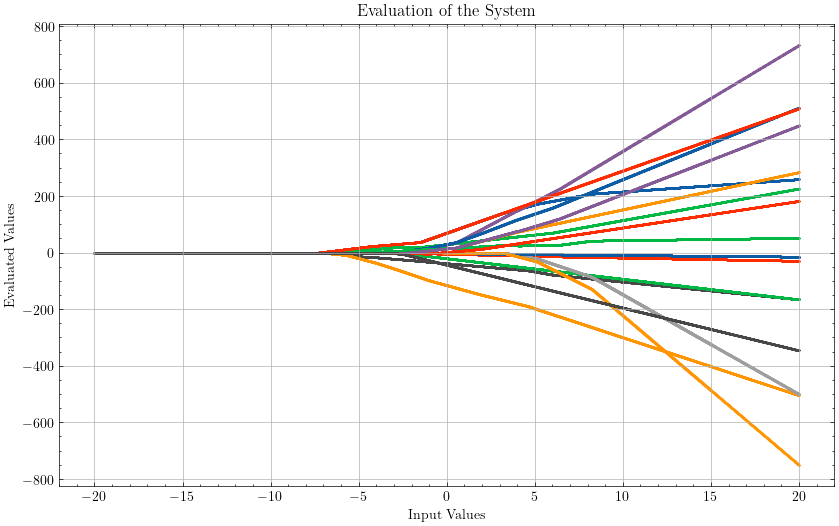

In [10]:
plt.figure(figsize=(10, 6))
for i in range(config['n_eqs']):
    plt.scatter(values[:, 0], evaluated_values[:, i], label=f'Equation {i+1}', s=0.1)
plt.xlabel('Input Values')
plt.ylabel('Evaluated Values')
plt.title('Evaluation of the System')
plt.grid(True)
plt.show()
plt.clf()
plt.close()

In [11]:
expanded_values = jnp.repeat(values, expected_number_of_nls, axis=1)
train_values = expanded_values[:train_size]
inbound_test = expanded_values[train_size:test_size + train_size]
outofbound_test = expanded_values[test_size + train_size:]

train_outputs, inbound_test_outputs = evaluated_values[:train_size], evaluated_values[train_size:test_size + train_size]
outofbound_test_outputs = evaluated_values[test_size + train_size:]

train_batches = create_batches(train_values, train_outputs, train_batch_size)
inbound_test_batches = create_batches(inbound_test, inbound_test_outputs, test_batch_size)
outofbound_test_batches = create_batches(outofbound_test, outofbound_test_outputs, test_batch_size)

In [12]:
print(train_values.shape, inbound_test.shape, outofbound_test.shape)
print(train_outputs.shape, inbound_test_outputs.shape, outofbound_test_outputs.shape)
print(len(train_batches), len(inbound_test_batches), len(outofbound_test_batches))
print(len(train_batches), len(train_batches[0]), len(train_batches[0][0]), len(train_batches[0][0][0]), len(train_batches[1][0][0]))
print(len(inbound_test_batches), len(inbound_test_batches[0]), len(inbound_test_batches[0][0]), len(inbound_test_batches[0][0][0]), len(inbound_test_batches[1][0][0]))
print(len(outofbound_test_batches), len(outofbound_test_batches[0]), len(outofbound_test_batches[0][0]), len(outofbound_test_batches[0][0][0]), len(outofbound_test_batches[1][0][0]))
print(type(train_batches[0]), type(train_batches[0][0]), type(train_batches[0][0][0]), type(train_batches[0][0][0][0]), type(train_batches[0][1][0]))


(10000, 200) (2000, 200) (2000, 200)
(10000, 20) (2000, 20) (2000, 20)
2 2 2
2 312 32 200 20
2 31 64 200 20
2 31 64 200 20
<class 'jaxlib.xla_extension.ArrayImpl'> <class 'jaxlib.xla_extension.ArrayImpl'> <class 'jaxlib.xla_extension.ArrayImpl'> <class 'jaxlib.xla_extension.ArrayImpl'> <class 'jaxlib.xla_extension.ArrayImpl'>


In [13]:
vectors = jnp.concatenate((state.params['params']['CustomActivation_0']['alpha'], state.params['params']['CustomActivation_0']['gamma']), axis=0).T
print(vectors)

[[ 0.00532239  0.00714493 -0.0140789   0.00454999 -0.02293794  0.00683664]
 [ 0.00794285 -0.01769428 -0.00338034 -0.00961454  0.01148725  0.00307049]
 [-0.01265172  0.00461983  0.00353754  0.00966763  0.00562015 -0.00740278]
 [-0.0088373   0.0148007  -0.00397315  0.00386923  0.00092771  0.00438353]
 [-0.00451383  0.00588339  0.00458301 -0.01107864 -0.00707142  0.01236508]
 [-0.00118079  0.00710852 -0.0010772   0.01157445  0.00603831  0.02277317]
 [ 0.00876648 -0.00210951 -0.01823763 -0.01055286  0.00146548  0.01059086]
 [ 0.00378797 -0.00902386 -0.00049722 -0.00341193 -0.00089004 -0.00102033]
 [ 0.00209711  0.01537324 -0.0033344  -0.01749108  0.01873896 -0.01112696]
 [-0.00213164  0.00031909  0.00519398  0.00799576 -0.01001314  0.00642764]]


In [14]:
num_epochs = 201

def train_epoch(carry, epoch):
    state, _ = carry  # Unpack state and dummy loss accumulator
    epoch_loss = jnp.array(0.0)

    # Loop over batches
    def batch_step(carry, batch):
        state, _ = carry
        batch_x, batch_y = batch
        state, train_loss = train_step(state, batch_x, batch_y)
        inbound_test_loss = evaluate((state, inbound_test_batches))
        outofbound_test_loss = evaluate((state, outofbound_test_batches))
        
        return (state, train_loss), (train_loss, inbound_test_loss, outofbound_test_loss)
    
    (state, _), (train_losses, inbound_test_losses, outofbound_test_losses) = lax.scan(batch_step, (state, 0.0), train_batches)


    # Print every n epochs
    print_condition = (epoch % 5 == 0)
    jax.lax.cond(
        print_condition,
        # True branch: print metrics
        lambda: jax.debug.print(
            "Epoch: {epoch}, Train Loss: {train_loss:.4f}, Inbound-Test Loss: {inbound_test_loss:.4f}, Outofbound-Test Loss: {outofbound_test_loss:.4f} ",
            epoch=epoch,
            train_loss=jnp.mean(train_losses),
            inbound_test_loss=jnp.mean(inbound_test_losses),
            outofbound_test_loss=jnp.mean(outofbound_test_losses),
        ),
        # False branch: do nothing
        lambda: None
    )
    return (state, epoch_loss), (train_losses, inbound_test_losses, outofbound_test_losses)

start_time = time.time()
(state, loss), (train_losses, inbound_test_losses, outofbound_test_losses) = lax.scan(train_epoch, (state, 0.0), jnp.arange(num_epochs))
jax.block_until_ready(state)
print("Training complete!")
end_time = time.time()
print(f"Total training time: {end_time - start_time:.4f} seconds")

Epoch: 0, Train Loss: 129.7863, Inbound-Test Loss: 2097.5285, Outofbound-Test Loss: 8620.1081 
Epoch: 5, Train Loss: 14.6150, Inbound-Test Loss: 223.3234, Outofbound-Test Loss: 1288.5721 
Epoch: 10, Train Loss: 10.5688, Inbound-Test Loss: 162.6688, Outofbound-Test Loss: 1102.0337 
Epoch: 15, Train Loss: 2.8576, Inbound-Test Loss: 44.8027, Outofbound-Test Loss: 279.6930 
Epoch: 20, Train Loss: 1.6778, Inbound-Test Loss: 26.4802, Outofbound-Test Loss: 169.7151 
Epoch: 25, Train Loss: 0.6552, Inbound-Test Loss: 10.4277, Outofbound-Test Loss: 84.5502 
Epoch: 30, Train Loss: 0.3147, Inbound-Test Loss: 4.9896, Outofbound-Test Loss: 38.5608 
Epoch: 35, Train Loss: 0.2044, Inbound-Test Loss: 3.2413, Outofbound-Test Loss: 21.6471 
Epoch: 40, Train Loss: 0.1450, Inbound-Test Loss: 2.3198, Outofbound-Test Loss: 13.2240 
Epoch: 45, Train Loss: 0.0931, Inbound-Test Loss: 1.4732, Outofbound-Test Loss: 7.0654 
Epoch: 50, Train Loss: 0.0463, Inbound-Test Loss: 0.7327, Outofbound-Test Loss: 2.4954 
Epo

In [15]:
plot_step = 1  # Adjust this value as needed
train_losses = train_losses.flatten()
inbound_test_losses = inbound_test_losses.flatten()
outofbound_test_losses = outofbound_test_losses.flatten()

# Generate steps for plotting
train_steps = jnp.arange(len(train_losses))[::plot_step]

train_plot = jnp.array(train_losses[::plot_step]).copy()
inbound_test_plot = jnp.array(inbound_test_losses[::plot_step]).copy()
outofbound_test_plot = jnp.array(outofbound_test_losses[::plot_step]).copy()

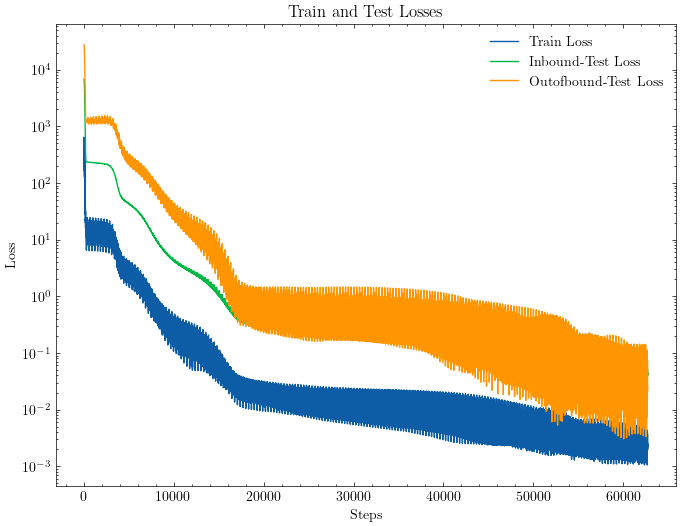

<Figure size 350x262.5 with 0 Axes>

In [16]:
# Plot the losses
plt.figure(figsize=(8, 6))
plt.plot(train_steps, train_plot, label='Train Loss', linewidth=1)
plt.plot(train_steps, inbound_test_plot, label='Inbound-Test Loss', linewidth=1)
plt.plot(train_steps, outofbound_test_plot, label='Outofbound-Test Loss', linewidth=1)
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.legend()
plt.yscale('log')
plt.title('Train and Test Losses')
plt.show()
plt.close()
plt.clf()


In [17]:
vectors = jnp.concatenate((state.params['params']['CustomActivation_0']['alpha'], state.params['params']['CustomActivation_0']['gamma']), axis=0).T
print(vectors)

[[-0.25433282 -0.24890537 -0.27253003  1.45296193  1.14982006  1.39228125]
 [-0.32005064 -0.24801651 -0.30859162  7.27390479  5.67857571  7.01617083]
 [-0.4233319  -0.08700184 -1.09065637 -5.02327653 -5.03020378 -8.28803096]
 [ 0.20329325  0.23016642  0.20506824 -0.61263205 -0.62579247 -0.58943129]
 [-0.41261095 -0.74403807 -0.40332719 -3.86747438 -6.06143093 -3.05618257]
 [ 0.25611236  0.16133801  0.3821919   4.42523119  2.54295889  5.69894218]
 [-0.28167967 -0.29488388 -0.31195311  2.49976288  2.51183367  2.52394696]
 [ 0.32469616  0.45954034  0.3630597  -3.08763011 -3.30094856 -3.23639834]
 [ 0.25127969  0.25987542  0.24564837 -0.57888613 -0.57795237 -0.57925342]
 [ 0.22027134  0.21978535  0.22637454  1.72825871  1.62304749  1.65938534]]


[Array(8, dtype=int64), Array(4, dtype=int64), Array(5, dtype=int64), Array(8, dtype=int64), Array(3, dtype=int64), Array(5, dtype=int64), Array(4, dtype=int64), Array(4, dtype=int64), Array(8, dtype=int64), Array(5, dtype=int64)]


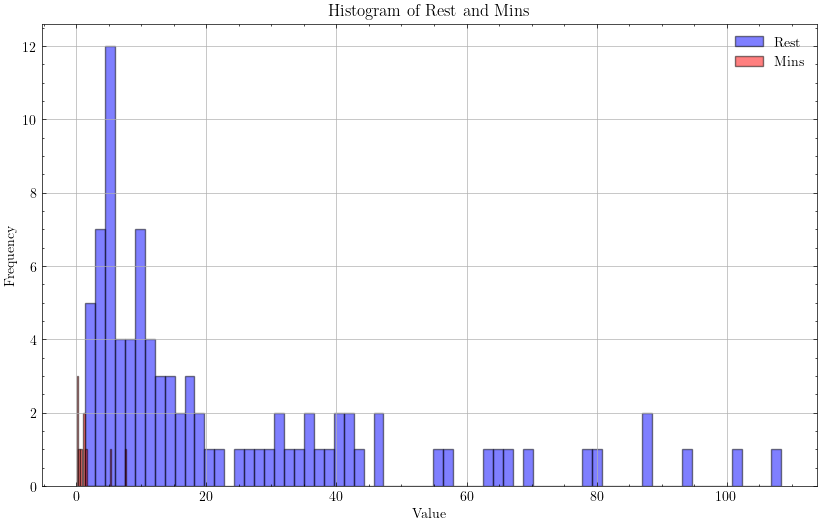

In [18]:
rest = []
mins = []
mins_nls = []

for vec in vectors:
    temp = []
    for nls in vec_nls:
        temp.append(jnp.abs(vec @ nls))
    
    min_value = jnp.min(jnp.array(temp))
    min_index = jnp.argmin(jnp.array(temp))  # Find the index of the minimum value
    
    mins.append(min_value)
    mins_nls.append(min_index)  # Store the `nls` corresponding to the minimum value
    
    # Remove the min value and associated nls
    temp.remove(min_value)
    rest.append(temp)
    
print(mins_nls)
    
plt.figure(figsize=(10, 6))
plt.hist([item for sublist in rest for item in sublist], bins=70, edgecolor='black', alpha=0.5, label='Rest', color='blue')
plt.hist(mins, bins=30, edgecolor='black', alpha=0.5, label='Mins', color='red')
plt.title('Histogram of Rest and Mins')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True)
plt.show()

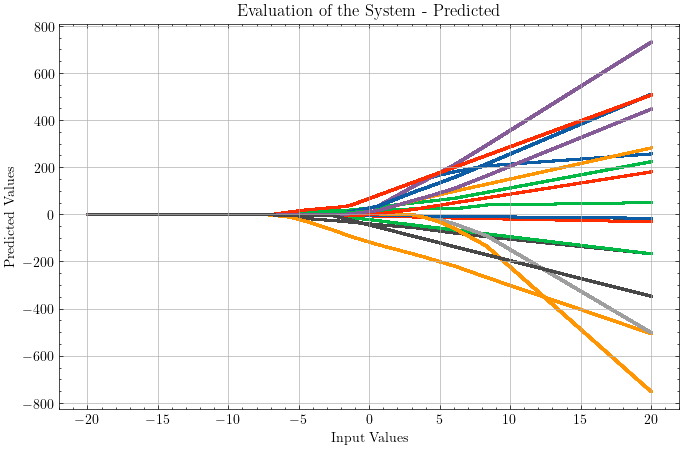

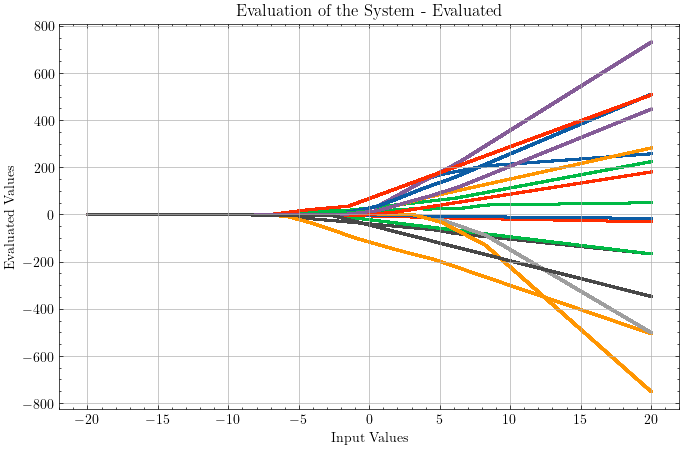

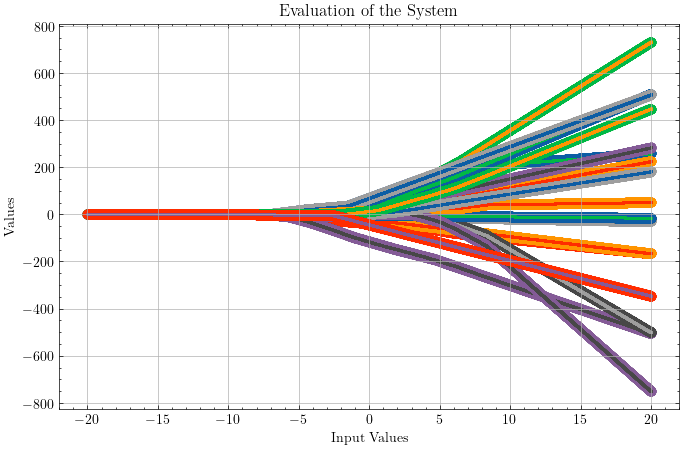

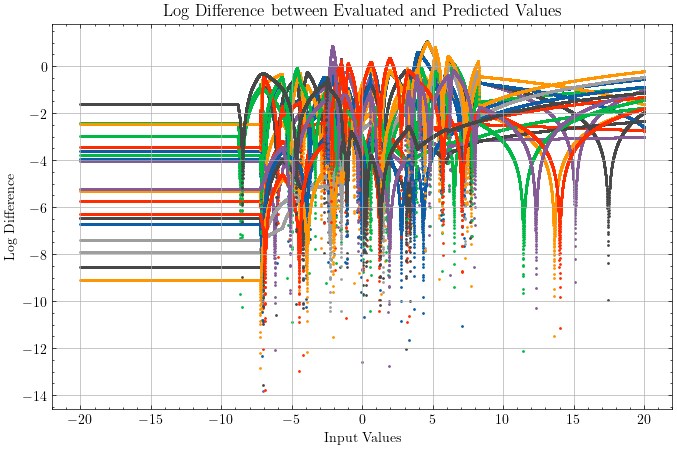

In [19]:
predicted_values = state.apply_fn(state.params, expanded_values)

plt.figure(figsize=(8, 5))
for i in range(config['n_eqs']):
    plt.scatter(values[:, i], predicted_values[:, i], label=f'Equation {i+1}', s=1)
plt.xlabel('Input Values')
plt.ylabel('Predicted Values')
plt.title('Evaluation of the System - Predicted')
plt.grid(True)
if config['n_eqs'] < 10:
    plt.legend()
plt.show()

plt.figure(figsize=(8, 5))
for i in range(config['n_eqs']):
    plt.scatter(values[:, i], evaluated_values[:, i], label=f'Equation {i+1}', s=1)
plt.xlabel('Input Values')
plt.ylabel('Evaluated Values')
plt.title('Evaluation of the System - Evaluated')
plt.grid(True)
if config['n_eqs'] < 10:
    plt.legend()
plt.show()

plt.figure(figsize=(8, 5))
for i in range(config['n_eqs']):
    plt.scatter(values[:, i], evaluated_values[:, i], label=f'True {i+1}')
    plt.scatter(values[:, i], predicted_values[:, i], label=f'Prediction {i+1}', s=1)
plt.xlabel('Input Values')
plt.ylabel('Values')
plt.title('Evaluation of the System')
plt.grid(True)
if config['n_eqs'] < 10:
    plt.legend()
plt.show()

plt.figure(figsize=(8, 5))
for i in range(config['n_eqs']):
    plt.scatter(values[:, i], jnp.log(jnp.abs(evaluated_values[:, i] - predicted_values[:, i]) + 1e-7), label=f'Error {i+1}', s=1)
plt.xlabel('Input Values')
plt.ylabel('Log Difference')
plt.title('Log Difference between Evaluated and Predicted Values')
plt.grid(True)
if config['n_eqs'] < 10:
    plt.legend()
plt.show()

plt.clf()
plt.close()


In [20]:
print(state.params['params']['Dense_0']['kernel'])
print(vec_nls)
print(vectors)

[[-0.61147285 -0.32133612 -0.01980701 ... -0.4228223  -0.1283364
   0.00191545]
 [-0.64008564 -0.14843713  0.07402755 ... -0.00779303  0.012472
  -0.03455584]
 [ 0.43237612 -0.00300125 -0.04568051 ...  0.03551745 -0.16998105
   0.06155368]
 ...
 [-0.1395691  -0.19734071 -0.17404357 ...  0.0653837  -0.22513008
  -0.08852145]
 [-0.10929509  0.06766047  0.44367757 ... -0.00097775  0.3751538
   0.10465518]
 [ 0.5765461   0.26387805  0.23578025 ...  0.16083312  0.18220015
  -0.11763778]]
[[-2.17664396e+00 -6.29406871e+00 -5.19491848e+00  3.93060866e+00
   7.06374360e+00 -4.58035497e+00]
 [-1.23063727e+00  8.39689247e+00  3.82128144e+00  4.30686470e+00
   1.51231557e+00  7.24401073e+00]
 [-9.10063268e-02 -2.85060975e-01 -6.88120963e+00  1.10358323e+00
   8.86721081e+00  2.59579719e+00]
 [-1.00054252e+01 -9.11655876e-03 -1.46862708e+00  5.71528543e+00
  -5.84395951e+00  4.20033569e+00]
 [ 4.36819991e+00  3.32054825e+00 -2.63901110e-01 -6.03676380e+00
   4.64757295e+00  1.70315899e+00]
 [ 6.63

### Uniform

In [21]:
system = Equations(config)

System and state loaded from equations_e26c00536e47a0085401091c2793c3ea.pkl


In [22]:
# Split random key
key, subkey = random.split(key)

# Generate new training values uniformly in [-bound, bound]
train_values = random.uniform(subkey, shape=(total_size, config['n_vars']), minval=-1 * bound, maxval=bound)

inbound_test = train_values[indices]  # Extract test points
train_values = train_values[mask]  # Remove them from training set

# Generate out-of-bound test values in [-bound-bound_delta, -bound] ∪ [bound, bound+bound_delta]
bound_delta = 5
key, subkey = random.split(key)
range1 = random.uniform(subkey, shape=(test_size//2, config['n_vars']), minval=-1*bound - bound_delta, maxval=-1*bound)
key, subkey = random.split(key)
range2 = random.uniform(subkey, shape=(test_size//2, config['n_vars']), minval=bound, maxval=bound + bound_delta)
outofbound_test = jnp.concatenate((range1, range2), axis=0)

# Stack both test sets
stacked_test = jnp.vstack((inbound_test, outofbound_test))

# Concatenate training and test values
values = jnp.vstack((train_values, stacked_test))

# Evaluate function on all values
evaluated_values = vmap(my_eval)(values)

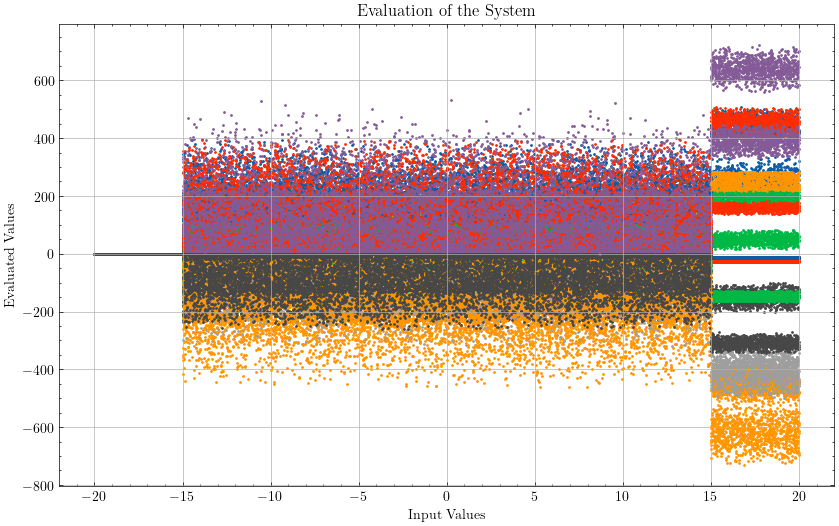

In [23]:
plt.figure(figsize=(10, 6))
for i in range(config['n_eqs']):
    plt.scatter(values[:, i], evaluated_values[:, i], label=f'Equation {i+1}', s=1)
plt.xlabel('Input Values')
plt.ylabel('Evaluated Values')
plt.title('Evaluation of the System')
plt.grid(True)
plt.show()
plt.clf()
plt.close()

In [24]:
expanded_values = jnp.repeat(values, expected_number_of_nls, axis=1)
train_values = expanded_values[:train_size]
inbound_test = expanded_values[train_size:test_size + train_size]
outofbound_test = expanded_values[test_size + train_size:]

train_outputs, inbound_test_outputs = evaluated_values[:train_size], evaluated_values[train_size:test_size + train_size]
outofbound_test_outputs = evaluated_values[test_size + train_size:]

train_batches = create_batches(train_values, train_outputs, train_batch_size)
inbound_test_batches = create_batches(inbound_test, inbound_test_outputs, test_batch_size)
outofbound_test_batches = create_batches(outofbound_test, outofbound_test_outputs, test_batch_size)

In [25]:
key, subkey = random.split(key)
params = model.init(subkey, dummy_input)
state = TrainState.create(apply_fn=model.apply, params=params, tx=optimizer)

In [26]:
num_epochs = 201

start_time = time.time()
(state, loss), (train_losses, inbound_test_losses, outofbound_test_losses) = lax.scan(train_epoch, (state, 0.0), jnp.arange(num_epochs))
jax.block_until_ready(state)
print("Training complete!")
end_time = time.time()
print(f"Total training time: {end_time - start_time:.4f} seconds")

Epoch: 0, Train Loss: 130.8638, Inbound-Test Loss: 2115.6291, Outofbound-Test Loss: 8689.5497 
Epoch: 5, Train Loss: 14.6151, Inbound-Test Loss: 223.3382, Outofbound-Test Loss: 1289.0854 
Epoch: 10, Train Loss: 10.5344, Inbound-Test Loss: 162.2421, Outofbound-Test Loss: 1121.8057 
Epoch: 15, Train Loss: 3.1413, Inbound-Test Loss: 49.0862, Outofbound-Test Loss: 320.2530 
Epoch: 20, Train Loss: 1.9880, Inbound-Test Loss: 31.2690, Outofbound-Test Loss: 196.1291 
Epoch: 25, Train Loss: 0.8511, Inbound-Test Loss: 13.6438, Outofbound-Test Loss: 96.2594 
Epoch: 30, Train Loss: 0.3673, Inbound-Test Loss: 5.8227, Outofbound-Test Loss: 41.7643 
Epoch: 35, Train Loss: 0.2227, Inbound-Test Loss: 3.5060, Outofbound-Test Loss: 22.6666 
Epoch: 40, Train Loss: 0.1648, Inbound-Test Loss: 2.6404, Outofbound-Test Loss: 14.8060 
Epoch: 45, Train Loss: 0.1293, Inbound-Test Loss: 2.0740, Outofbound-Test Loss: 10.2236 
Epoch: 50, Train Loss: 0.0947, Inbound-Test Loss: 1.4957, Outofbound-Test Loss: 6.7695 
Ep

In [27]:
plot_step = 1  # Adjust this value as needed
train_losses = train_losses.flatten()
inbound_test_losses = inbound_test_losses.flatten()
outofbound_test_losses = outofbound_test_losses.flatten()

# Generate steps for plotting
train_steps = jnp.arange(len(train_losses))[::plot_step]

train_plot = jnp.array(train_losses[::plot_step]).copy()
inbound_test_plot = jnp.array(inbound_test_losses[::plot_step]).copy()
outofbound_test_plot = jnp.array(outofbound_test_losses[::plot_step]).copy()

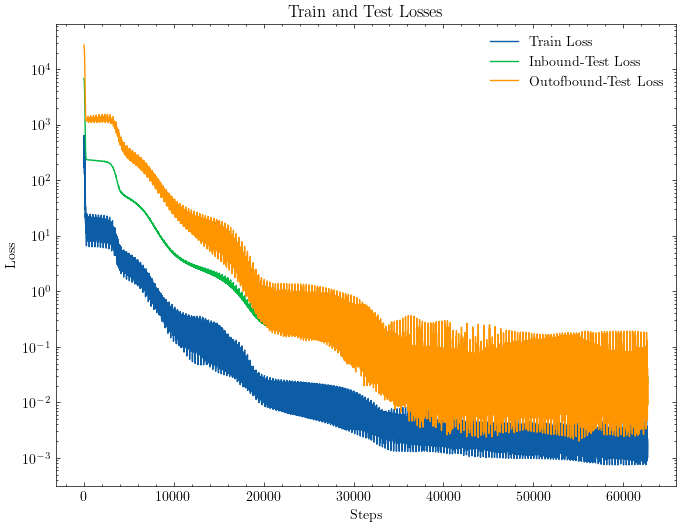

<Figure size 350x262.5 with 0 Axes>

In [28]:
# Plot the losses
plt.figure(figsize=(8, 6))
plt.plot(train_steps, train_plot, label='Train Loss', linewidth=1)
plt.plot(train_steps, inbound_test_plot, label='Inbound-Test Loss', linewidth=1)
plt.plot(train_steps, outofbound_test_plot, label='Outofbound-Test Loss', linewidth=1)
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.legend()
plt.yscale('log')
plt.title('Train and Test Losses')
plt.show()
plt.close()
plt.clf()

[Array(8, dtype=int64), Array(8, dtype=int64), Array(9, dtype=int64), Array(0, dtype=int64), Array(8, dtype=int64), Array(4, dtype=int64), Array(4, dtype=int64), Array(4, dtype=int64), Array(4, dtype=int64), Array(8, dtype=int64)]


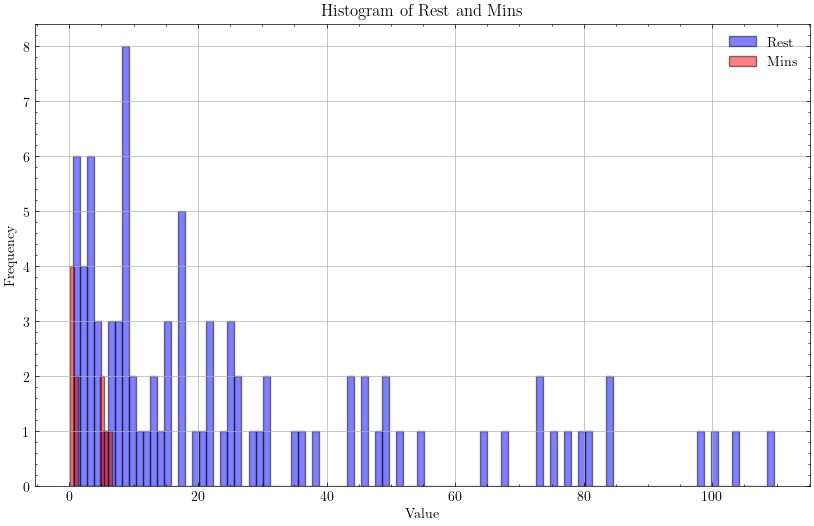

In [29]:
vectors = jnp.concatenate((state.params['params']['CustomActivation_0']['alpha'], state.params['params']['CustomActivation_0']['gamma']), axis=0).T

rest = []
mins = []
mins_nls = []

for vec in vectors:
    temp = []
    for nls in vec_nls:
        temp.append(jnp.abs(vec @ nls))
    
    min_value = jnp.min(jnp.array(temp))
    min_index = jnp.argmin(jnp.array(temp))  # Find the index of the minimum value
    
    mins.append(min_value)
    mins_nls.append(min_index)  # Store the `nls` corresponding to the minimum value
    
    # Remove the min value and associated nls
    temp.remove(min_value)
    rest.append(temp)
    
print(mins_nls)
    
plt.figure(figsize=(10, 6))
plt.hist([item for sublist in rest for item in sublist], bins=100, edgecolor='black', alpha=0.5, label='Rest', color='blue')
plt.hist(mins, bins=10, edgecolor='black', alpha=0.5, label='Mins', color='red')
plt.title('Histogram of Rest and Mins')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True)
plt.show()


In [30]:
print(vectors)
print(vec_nls)

[[ 0.44013162  0.46250575  0.43641713 -3.81793103 -3.12394289 -3.10553649]
 [ 0.19431819  0.19506524  0.20255383 -0.53524927 -0.53559073 -0.5336529 ]
 [-0.2274318  -0.41231749 -0.27050681  2.68920433  5.74408461  4.42258602]
 [-0.22648761 -0.21480828 -0.21268254 -0.4850601  -0.48529595 -0.48541925]
 [-0.36274053 -0.35574976 -0.37797132  1.29971584  1.50894199  1.50763183]
 [ 0.17292292  0.83270435  0.18003844 -4.56801677 -6.26018067 -4.16308156]
 [ 0.35611899  0.34851132  0.34621547  2.65365704  2.04952789  2.47836043]
 [-0.44357201 -0.25114727 -0.18001689  7.26964669  6.80778452  5.68974759]
 [ 0.49233239  0.65902385  0.72465979 -8.2332703  -8.23918058 -5.2017124 ]
 [ 0.12353125  0.15092633  0.16934019 -0.73065126 -2.07944241 -2.30912722]]
[[-2.17664396e+00 -6.29406871e+00 -5.19491848e+00  3.93060866e+00
   7.06374360e+00 -4.58035497e+00]
 [-1.23063727e+00  8.39689247e+00  3.82128144e+00  4.30686470e+00
   1.51231557e+00  7.24401073e+00]
 [-9.10063268e-02 -2.85060975e-01 -6.88120963e+

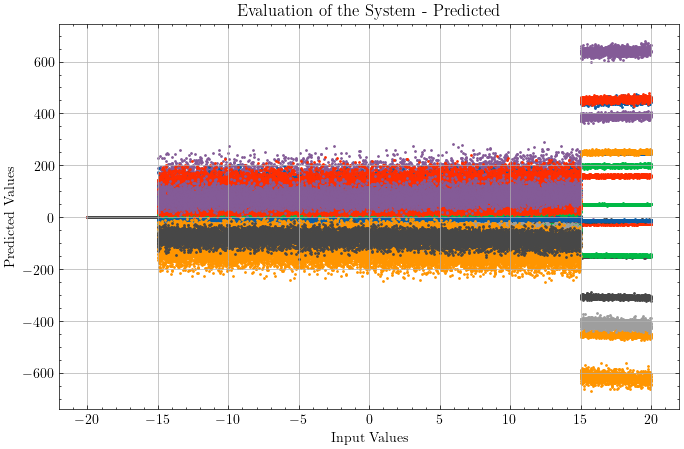

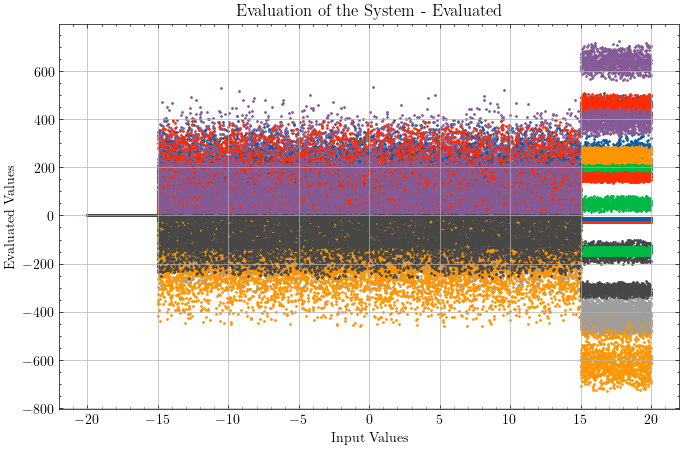

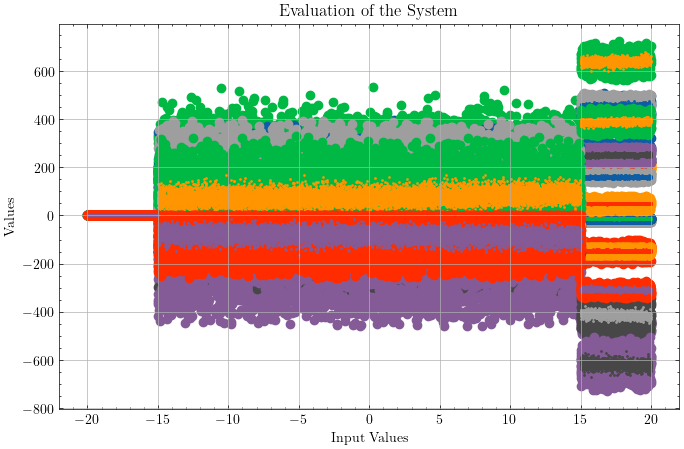

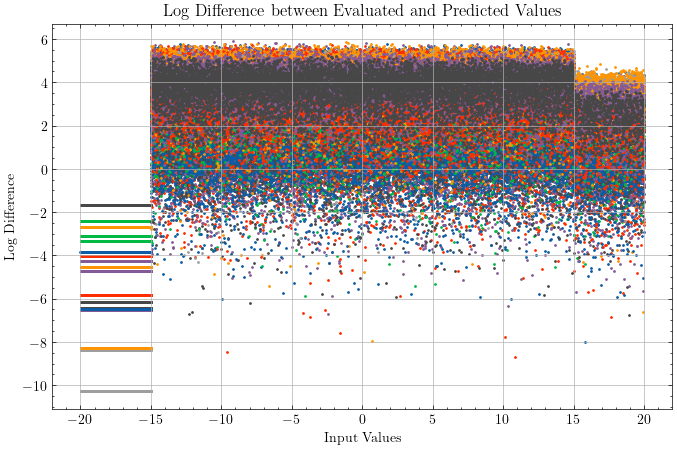

In [31]:
predicted_values = state.apply_fn(state.params, expanded_values)

plt.figure(figsize=(8, 5))
for i in range(config['n_eqs']):
    plt.scatter(values[:, i], predicted_values[:, i], label=f'Equation {i+1}', s=1)
plt.xlabel('Input Values')
plt.ylabel('Predicted Values')
plt.title('Evaluation of the System - Predicted')
plt.grid(True)
if config['n_eqs'] < 10:
    plt.legend()
plt.show()

plt.figure(figsize=(8, 5))
for i in range(config['n_eqs']):
    plt.scatter(values[:, i], evaluated_values[:, i], label=f'Equation {i+1}', s=1)
plt.xlabel('Input Values')
plt.ylabel('Evaluated Values')
plt.title('Evaluation of the System - Evaluated')
plt.grid(True)
if config['n_eqs'] < 10:
    plt.legend()
plt.show()

plt.figure(figsize=(8, 5))
for i in range(config['n_eqs']):
    plt.scatter(values[:, i], evaluated_values[:, i], label=f'True {i+1}')
    plt.scatter(values[:, i], predicted_values[:, i], label=f'Prediction {i+1}', s=1)
plt.xlabel('Input Values')
plt.ylabel('Values')
plt.title('Evaluation of the System')
plt.grid(True)
if config['n_eqs'] < 10:
    plt.legend()
plt.show()

plt.figure(figsize=(8, 5))
for i in range(config['n_eqs']):
    plt.scatter(values[:, i], jnp.log(jnp.abs(evaluated_values[:, i] - predicted_values[:, i])), label=f'Error {i+1}', s=1)
plt.xlabel('Input Values')
plt.ylabel('Log Difference')
plt.title('Log Difference between Evaluated and Predicted Values')
plt.grid(True)
if config['n_eqs'] < 10:
    plt.legend()
plt.show()

plt.clf()
plt.close()


In [32]:
print(state.params['params']['Dense_0']['kernel'])


[[-0.22740918 -0.17270416 -0.21515197 ... -0.00353467 -0.06306207
  -0.06378645]
 [-0.05447504 -0.03816553  0.3267348  ...  0.10296638  0.23966455
   0.07571237]
 [ 0.40965694 -0.0995326  -0.12963814 ...  0.1377162   0.06579605
  -0.0595481 ]
 ...
 [-0.7351     -0.21673378 -0.07544484 ...  0.09397251  0.0066923
   0.12585379]
 [-0.26409414  0.02569892  0.0106811  ...  0.01014931  0.02029386
  -0.00471839]
 [-0.2622376   0.07470997  0.17726888 ...  0.30276084  0.17368723
  -0.10239304]]
